In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import json
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from lightgbm import LGBMClassifier


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import category_encoders as ce
import sweetviz as sv

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import custom functions 
from utils.utils import make_bar_plot, get_high_season, train_base_model, plot_feature_importance 

In [4]:
base_color = '#3B3B3B'

In [5]:
# Load the data
data_dir = 'data/raw/'
data_file = 'dataset_SCL.csv'

# use pathlib to create a path to the data file 
data_path = Path(data_dir + data_file)

In [44]:
df = pd.read_csv(data_path,low_memory=False) 

display(df.head())

df.shape

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


(68206, 18)

### Question 1: How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?


In [45]:
# I start with some quick validations, e.g. in the bellow series we can see that there are 3 columnns with constant values, which are not useful for the model. 
df.nunique()

Fecha-I      53252
Vlo-I          584
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          861
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

In [46]:
# Next I search for missing values
df.isnull().sum().to_frame().T

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
df[df.isnull().any(axis=1)]


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


In [48]:
# since there is only one missing value we can drop the row 
df = df.dropna()

In [49]:
# regarding the data types, the dates are as strings, so I convert them to datetime 

display(df.dtypes.to_frame().T)

df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])


display(df.dtypes.to_frame().T)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,object,object,object,object,object


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,datetime64[ns],object,object,object,object,datetime64[ns],object,object,object,object,int64,int64,int64,object,object,object,object,object


In [50]:
# create two new columns for the year and month  
#df['year'] = df['Fecha-I'].dt.year
#df['month'] = df['Fecha-I'].dt.month


## Univariate analysis 

In [51]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


I'll start looking for patterns in the data that may help to create decide the data transformation steps.


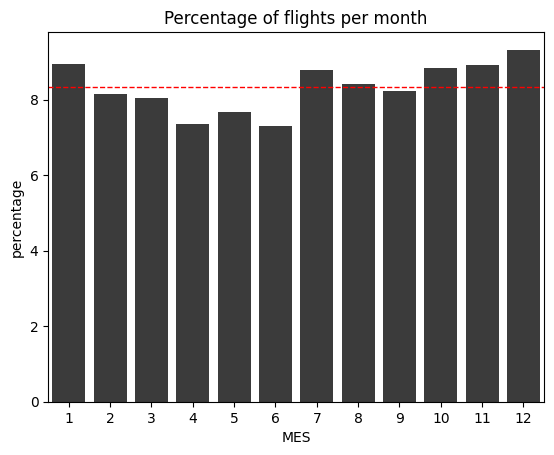

In [52]:
# From the above plot we can see that the number of flights is not evenly distributed across the months. 
# It seems to be some seasonal pattern, since the months with the highest number of flights are the consecutive (October, November, December and January) this could be due to the summer and vacation season in Chile 

make_bar_plot(df,'MES','Percentage of flights per month')

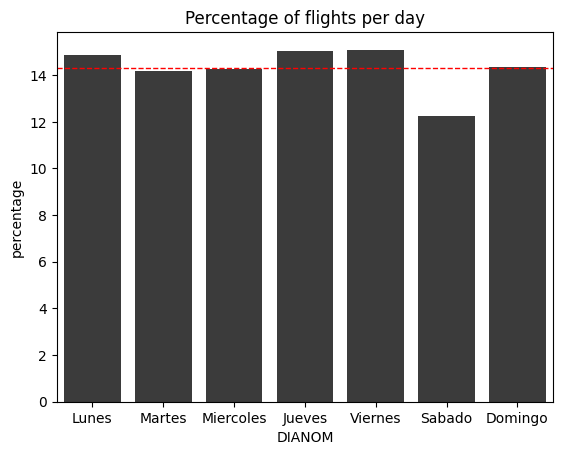

In [53]:
# For the days we can see an interesting pattern,
# the number of flights on Monday is higher than the average, which could be related to work flights, to take most of the weekdays  
# a similar pattern is observed on thrusday and friday which could be related to travel for the weekend 

day_map = {'Lunes':1, 'Martes':2, 'Miercoles':3, 'Jueves':4, 'Viernes':5, 'Sabado':6, 'Domingo':7}

make_bar_plot(df,'DIANOM','Percentage of flights per day',day_map)

In [54]:
# The Scheduled fligths have 116 more unique values than the actual fligths, 
# this could have a correlation with the delay of the fligths 

print ("'Vlo-I ' has {} unique values".format(df['Vlo-I'].nunique()))
display (df['Vlo-I'].value_counts(dropna=False).to_frame().T)

print ("'Vlo-O ' has {} unique values".format(df['Vlo-O'].nunique()))
display (df['Vlo-O'].value_counts(dropna=False).to_frame().T)

'Vlo-I ' has 584 unique values


,174,11,116,150,704,162,164,118,172,170,...,1218,1906,1158,1154,1351,1121,1116,1065,1054,1234
Vlo-I,686,645,608,557,556,553,550,508,498,495,...,1,1,1,1,1,1,1,1,1,1


'Vlo-O ' has 861 unique values


,174,11,116,150,704,162,164,118,172,170,...,9701,9662,9629,9600,9956,2726,9860,9858,1297,1134
Vlo-O,649,646,608,517,514,512,508,507,466,452,...,1,1,1,1,1,1,1,1,1,1


In [55]:
# The variables 'Vlo-I' and 'Vlo-O' are constant, hence we will not use them in the rest of the analysis 

display (df['Ori-I'].value_counts(dropna=False).to_frame().T)

display (df['Ori-O'].value_counts(dropna=False).to_frame().T)


df = df.drop(['Vlo-I','Vlo-O'],axis=1) 

,SCEL
Ori-I,68205


,SCEL
Ori-O,68205


In [56]:
# At first glance we can see there are a few differences between Des-I and Des-O, 
# this could be relevant for stimated delays 

display (df['Des-I'].value_counts(dropna=False).to_frame().T)

display (df['Des-O'].value_counts(dropna=False).to_frame().T)

,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SBCT,SAZS,SLCB,EGYP,SBFI,SPSO,SEQU,SEQM,SARI
Des-I,5787,5269,5145,4357,3995,3747,3570,3240,3094,2583,...,6,3,2,1,1,1,1,1,1,1


,SCFA,SPJC,SCCF,SCTE,SCIE,SCDA,SBGR,SAEZ,SABE,SCQP,...,SULS,SAWH,SBCT,SBFI,SAZS,SEQM,KIAD,SPSO,EGYP,SLCB
Des-O,5786,5269,5146,4357,3993,3747,3569,3241,3094,2589,...,6,6,3,2,2,2,1,1,1,1


In [57]:
# We can see that there are significant discrepancies between Emp-I and Emp-O

display (df['Emp-I'].value_counts(dropna=False).to_frame().T    )

display (df['Emp-O'].value_counts(dropna=False).to_frame().T)

,LAN,SKU,TAM,ARG,CMP,LAW,AVA,JAT,GLO,AAL,...,BAW,QFU,JMR,LRC,AUT,PUE,LXP,LPE,DSM,LNE
Emp-I,37611,14298,3049,1949,1850,1573,1152,1095,806,757,...,205,195,100,92,74,49,9,4,2,1


,LAN,LXP,SKU,TAM,ARG,CMP,JMR,LPE,JAT,AVA,...,AZA,KLM,LAP,BAW,QFA,AUT,PUE,56R,48O,TPU
Emp-O,20988,14558,14298,3046,1946,1850,1647,1214,1095,885,...,259,251,219,205,195,77,49,16,10,2


In [58]:
# For Fecha-I and Fecha-O we can see that Fecha-O has more unique values, which is expected since 
#  the programed flighs use to have more round times e.g. 12:00 vs a delayed flight that could be 12:03 

display (df['Fecha-I'].value_counts(dropna=False).to_frame().T)
display (df['Fecha-O'].value_counts(dropna=False).to_frame().T)

,2017-07-28 13:30:00,2017-03-19 18:00:00,2017-03-26 18:00:00,2017-12-16 13:35:00,2017-02-15 13:35:00,2017-04-02 18:00:00,2017-09-06 12:00:00,2017-07-29 06:45:00,2017-08-01 05:00:00,2017-06-27 05:00:00,...,2017-06-05 15:16:00,2017-06-27 06:53:00,2017-06-28 06:53:00,2017-06-29 06:53:00,2017-06-30 06:53:00,2017-06-01 15:16:00,2017-06-02 15:16:00,2017-06-03 15:16:00,2017-06-04 15:16:00,2017-12-31 14:55:00
Fecha-I,6,6,6,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1


,2017-05-19 07:01:00,2017-11-05 14:51:00,2017-10-25 07:37:00,2017-03-08 13:34:00,2017-09-07 20:10:00,2017-02-12 09:12:00,2017-05-28 08:12:00,2017-05-23 08:50:00,2017-02-15 09:20:00,2017-12-01 13:49:00,...,2017-05-30 11:44:00,2017-05-31 11:04:00,2017-05-01 17:10:00,2017-05-02 17:03:00,2017-05-03 17:03:00,2017-05-04 15:48:00,2017-05-05 17:02:00,2017-05-07 17:03:00,2017-05-08 17:06:00,2017-12-31 15:04:00
Fecha-O,5,5,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1


<AxesSubplot: >

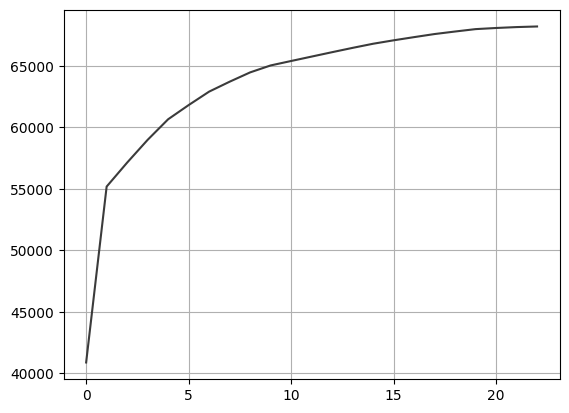

In [59]:
# We can also see that a few airlines account for the majority of the flights

df['OPERA'].value_counts(dropna=False).sort_values(ascending=False).to_frame().T

df.groupby('OPERA').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color='#3B3B3B',grid=True)


,SIGLAORI,counts
0,Santiago,68205


,SIGLADES,counts
8,Buenos Aires,6335
0,Antofagasta,5786
28,Lima,5269
9,Calama,5146
42,Puerto Montt,4357
...,...,...
12,Cataratas Iguacu,2
41,"Pisco, Peru",1
44,Puerto Stanley,1
15,Cochabamba,1


array([[<AxesSubplot: title={'center': 'counts'}>]], dtype=object)

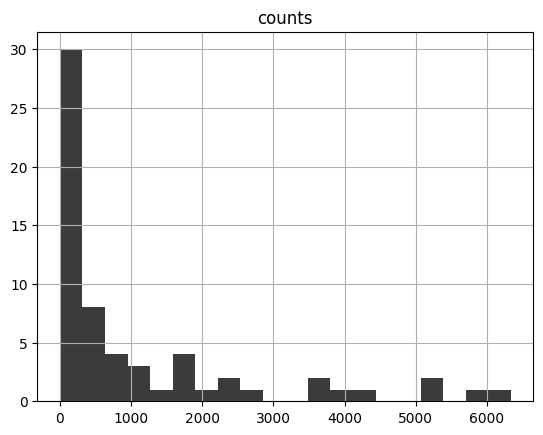

In [60]:
# For the origin airport we can see that all the flights are from Santiago (SCL)

display (df.groupby('SIGLAORI').size().reset_index(name='counts'))

# for the destination there is a large dispersion on the number of flights, some cities have accounts for about  10% of the total flights 
# and others have only 1 or 2 flights

display (df
.groupby('SIGLADES')
.size()
.reset_index(name='counts')
.sort_values(by='counts', ascending=False)
)


df.groupby('SIGLADES').size().reset_index(name='counts').hist(color=base_color,bins=20)

40923.6

<AxesSubplot: >

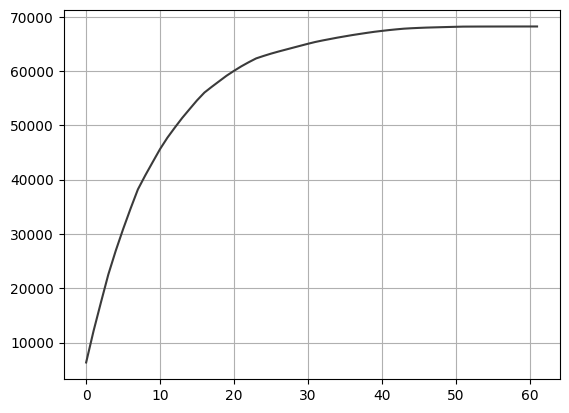

In [63]:
# from the below plot we can see that the top 10 destinations account for about 60%  (40k) of the total flights 
df.groupby('SIGLADES').size().reset_index(name='counts').sort_values(by='counts', ascending=False).cumsum().reset_index()['counts'].plot(color=base_color,grid=True)


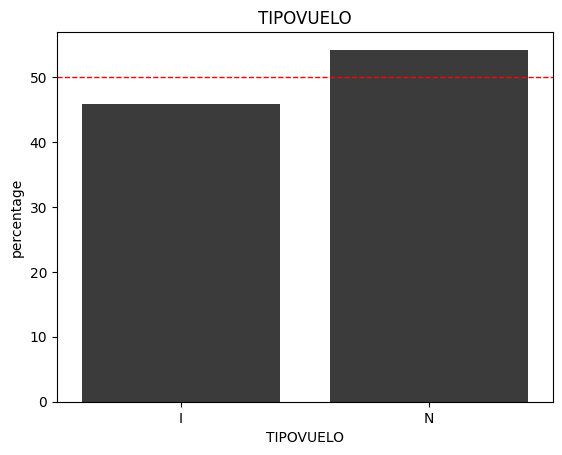

In [64]:
# Regarding the type of flight we can see that the majority of the flights are domestic flights (Nacional)
# but the percentage of international flights is close to half of the domestic flights.
df['TIPOVUELO'].value_counts(dropna=False).to_frame().T
make_bar_plot(df, 'TIPOVUELO', 'TIPOVUELO', key_map={})


## Question 2: 

Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:


* high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
* min_diff : difference in minutes between Date-O and Date-I .
* delay_15 : 1 if min_diff > 15, 0 if not.
* period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .




In [65]:

df['high_season'] = get_high_season(df)

df[['MES','DIA','high_season']]


,MES,DIA,high_season
0,1,1,1
1,1,2,1
2,1,3,1
3,1,4,1
4,1,5,1
...,...,...,...
68201,12,22,1
68202,12,25,1
68203,12,27,1
68204,12,29,1


In [66]:
# convert df['Fecha-O'] and  df['Fecha-I'] to datetime format 
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])

# min_diff : difference in minutes between Date-O and Date-I . 
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60

# delay_15 : 1 if min_diff > 15, 0 if not. 
df['delay_15'] = 0
df.loc[df['min_diff'] > 15, 'delay_15'] = 1



In [67]:
# period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I use dt.hour to extract the hour.


df['period_day'] = 'morning'
df.loc[(df['Fecha-I'].dt.hour  >= 12) & (df['Fecha-I'].dt.hour  <= 18), 'period_day'] = 'afternoon'
df.loc[(df['Fecha-I'].dt.hour  >= 19) | (df['Fecha-I'].dt.hour  <= 4), 'period_day'] = 'night'


In [68]:
df[['period_day','Fecha-I']].sample(10)

,period_day,Fecha-I
53829,morning,2017-10-26 07:55:00
16666,morning,2017-03-03 09:35:00
14941,morning,2017-03-25 07:15:00
25783,night,2017-05-21 20:50:00
36347,morning,2017-07-30 09:20:00
60619,night,2017-11-30 23:30:00
67833,night,2017-12-25 04:00:00
11991,night,2017-03-04 22:30:00
7471,afternoon,2017-02-06 17:15:00
56624,night,2017-11-24 00:55:00


In [69]:
# list of high_season min_diff delay_15 period_day
synthetic_features_names =  ['high_season', 'min_diff', 'delay_15', 'period_day']

In [70]:
synthetic_features = df[synthetic_features_names]

synthetic_features

,high_season,min_diff,delay_15,period_day
0,1,3.0,0,night
1,1,9.0,0,night
2,1,9.0,0,night
3,1,3.0,0,night
4,1,-2.0,0,night
...,...,...,...,...
68201,1,46.0,1,afternoon
68202,1,16.0,1,afternoon
68203,1,40.0,1,afternoon
68204,1,13.0,0,afternoon


In [71]:
df = df.drop(synthetic_features_names,axis=1)  

In [72]:
# the output files are stored in the data/interim folder 
# so its not necessary to repete all the steps in the notebook

df.to_csv('data/interim/dataset_SCL.csv', index=False)
synthetic_features.to_csv('data/interim/synthetic_features_SCL.csv', index=False)

### Question 3:

What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? 

What variables would you expect to have the most influence in predicting delays?

In [77]:
# load the data from the previous step 
synthetic_features = pd.read_csv('data/interim/synthetic_features_SCL.csv') 
df = pd.read_csv('data/interim/dataset_SCL.csv')
# merge on index 
dataset  = pd.concat([df, synthetic_features], axis=1)


In [78]:
synthetic_features['delay_15'].value_counts(dropna=False).to_frame().T

,0,1
delay_15,55591,12614


### At this stage I've stplit the data into train and test, the reson for this is to have "new data" to evaluate the model that have not been seen during the EDA. 
### Ideally this would be made by date, so the training data is e.g. 2016-2018 and the test is 2019 since there can be some trends at that frequency 
### In this case, there is only data from 2017 (and 2 records from 2018) so the data will the split randomly  



In [79]:

# Create the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Loop through the splits
X,y = dataset.drop(['delay_15'] ,axis=1) , dataset['delay_15'] 
for train_index, test_index in splitter.split(X, y):
    # Get the training and test data
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

In [80]:
# save X_train, X_test, y_train, y_test to csv files in data/interim folder 
X_train.to_csv('data/interim/X_train_SCL.csv', index=False)
X_test.to_csv('data/interim/X_test_SCL.csv', index=False)
y_train.to_csv('data/interim/y_train_SCL.csv', index=False)
y_test.to_csv('data/interim/y_test_SCL.csv', index=False)


In [81]:
## For this analysis only the training data will be used. 
# to avoid possible error for mutability the previous dataframes are deleted 
del X_train, X_test, y_train, y_test, X, y, df, dataset 

In [83]:
# load the training data 

X_train = pd.read_csv('data/interim/X_train_SCL.csv')
y_train = pd.read_csv('data/interim/y_train_SCL.csv') 

df_train = pd.concat([X_train, y_train], axis=1) 

The variables to analyze are: : 

* the delay rate across 
* destination
* airline
* month of the year
* day of the week
* season
* type of flight

For this plot I leverage on the sweetviz library, the complete report can be found in the HTML file in the reports folder. 

In [66]:
# The column MES_Name is created only for the purpose of the report. 
df_train['MES_Name'] = df_train['MES'].map({1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'})

my_report = sv.analyze(df_train[['Des-I','Emp-I','Des-O','Emp-O','TIPOVUELO','period_day','high_season','DIANOM','MES_Name','OPERA', 'delay_15']],target_feat='delay_15')

/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: delay_15 (TARGET)                   |▊         | [  8%]   00:00 -> (00:01 left)/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: Des-I                               |█▋        | [ 17%]   00:00 -> (00:02 left)/home/codespace/.

In [83]:
# the complete report is saved in the reports folder 
my_report.show_html(filepath='./reports/EDA_base_report.html') 

Report ./reports/EDA_base_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Now I'll analyze the plots from the report

For reference, all the plots have two graphs:

* The bars represent the percentage of that class over the total. 
In the below plot from all the records about 55% are 'N' the other 45% is 'I' 

* The lines represent the percentage of the target variable within each category.
In the below plot, among the 'N' records 15% are positive, and among the 'I' records 24% are positive interms of the target variable (have a delay)



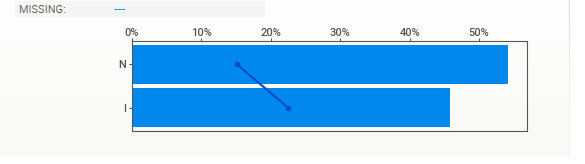


From the image below we can see that there is significant variation in the delay time between the destinations, hence is a good idea to include this feature in the model.  

The main challenge we face to do it right is the high cardinality of the feature. 
It is not reasonable to create a dummy variable for each destination nor to use an ordinal encoding. 
At this point we have some alternatives:

1. use a target encoding
2. use WOE encoding 
3. Make a manual encoding based on the EDA 


But the high cardinality of the feature is still a problem. Since it may lead to overfitting. 


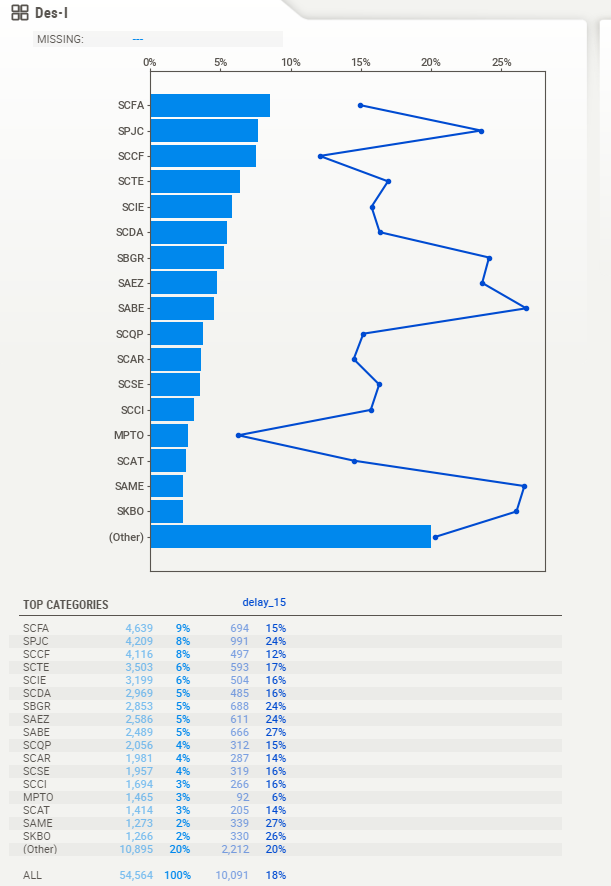

For the airline we have a similar behavior than with the destination, hence I will use the same approach.

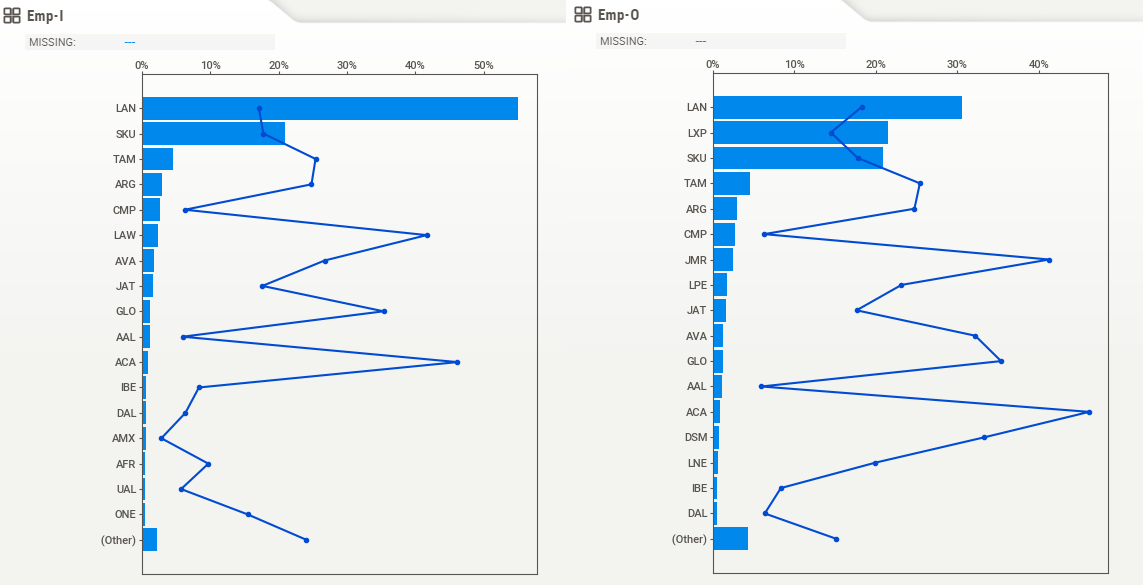

The OPERA column provides similar information than Emp-I and Emp-O, for the moment we will use the same approach of grouping and encoding and decide at a later stage which one to keep 

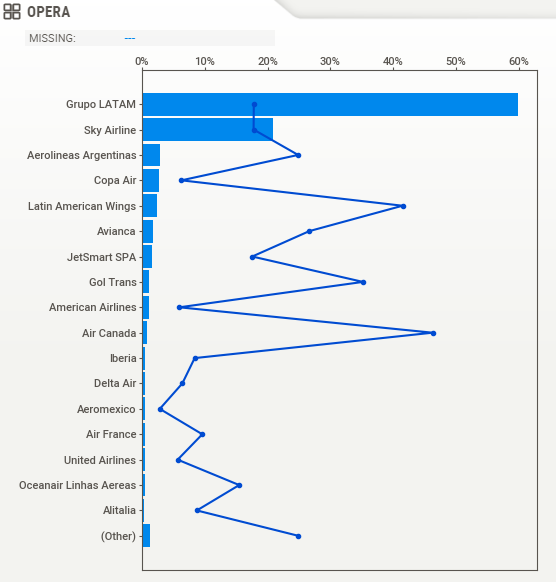

For the month feature, there are also differences in the delay_15 distribution.  

In particular, the months of December and July have a higher percentage of delays.
maybe related to a higher demand for flights in these months. 

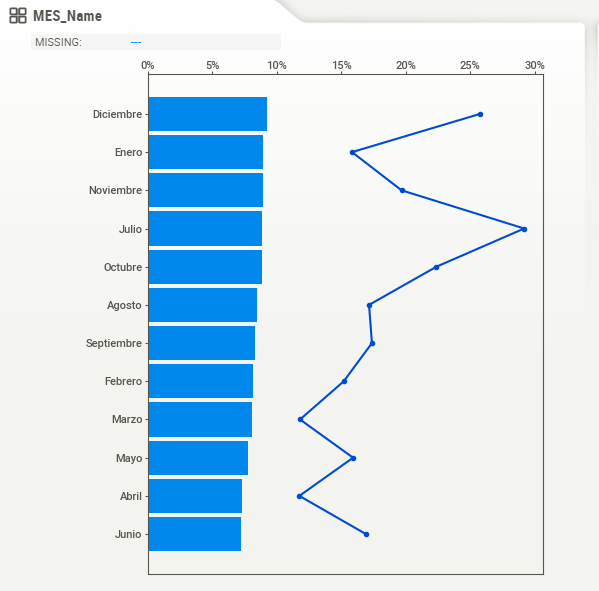

For the flight type, the analysis is straightforward, on average the delay is higher for international flights than for domestic flights.  


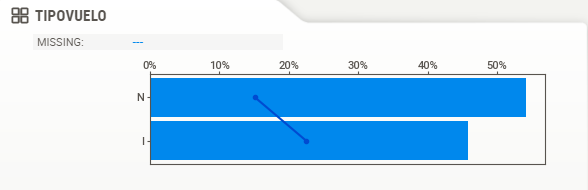

During the high season the delays rate is larger 

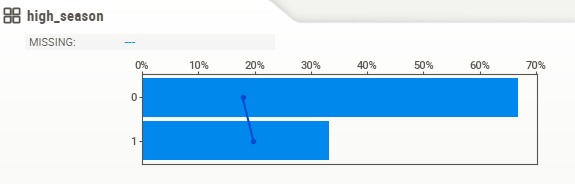

Regarding the Period of the day, during the morning the rate of delays is smaller hence this is a variable that could be used for the model and may be binary

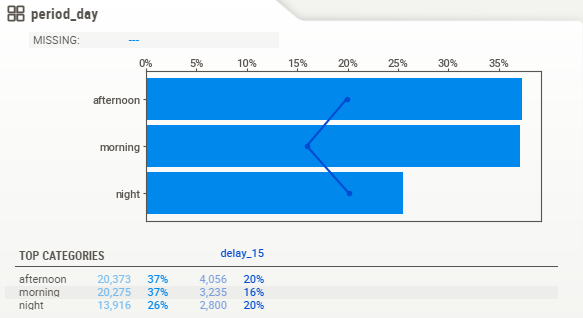

For the day of the week we can also see a relation with the delay, for this variable we will just make a flag for the days with Longer delay: 

long_delay_day: Jueves, Viernes, Lunes 


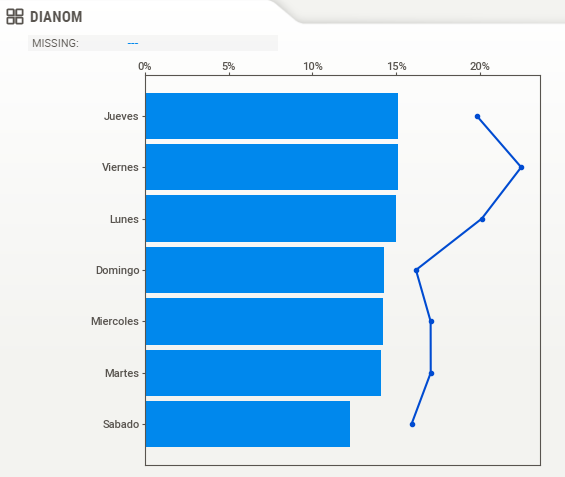

### Feature Engineering 

In [10]:
# for bining the high cardinality categories I'll take as reference the number of flights per category.
# if is lower than 100 the category will be binned as 'other'
fligths_th = 100

main_destination =  df_train['Des-I'].value_counts().loc[lambda x: x > fligths_th].index

# To store the mapping I'll use a defaultdict, which requires the definition of a function to be saved in the pickle file.
# Its no possible to save a lambda function nor as as json file.

def default_val():
  return 'other'

destination_mapping = defaultdict(default_val)
for k in main_destination:
    destination_mapping[k] = k

with open('data/processed/destination_mapping_SCL.pkl' ,'wb') as f:
  # Serialize the defaultdict and write it to the file
  pickle.dump(destination_mapping, f)


# For the airline we will use the same approach, with the difference that we will have to work with to columns Emp-I and Emp-O. 
# ideally both shlould be the same, but close to the date of this dataset there was a merge between airlines I'm asuming that's the reason for the discrepancy.
# Using both variables in the model does not sound like a great idea, since it will add a complexity hard to justify 
# but we will create both and see which performs better. 

# select the airlines with more than 100 flights use the value_counts method 

main_airline_I = df_train['Emp-I'].value_counts().loc[lambda x: x > fligths_th].index
main_airline_O = df_train['Emp-O'].value_counts().loc[lambda x: x > fligths_th].index

main_airline = main_airline_I.append(main_airline_O).unique()

main_airline

# create a default dictionary with main_airline as keys if the k is in the list return the same k, if not return 'other'
airline_mapping = defaultdict(default_val)
for k in main_airline:
    airline_mapping[k] = k

# save airline_mapping to as a as pickle file
with open('data/processed/airline_mapping_SCL.pkl' ,'wb') as f:
  pickle.dump(airline_mapping, f)


main_airline_op = df_train['OPERA'].value_counts().loc[lambda x: x > fligths_th].index

airline_mapping_op = defaultdict(default_val)
for k in main_airline_op:
    airline_mapping_op[k] = k

# save airline_mapping to as a pickle file
with open('data/processed/airline_mapping_op_SCL.pkl' ,'wb') as f:
  pickle.dump(airline_mapping_op, f)

  

In [11]:
# The days mapping is a bit different, since I want to create a binary variable
# it can be stored as a json file

longer_delay_days = ['Jueves','Viernes','Lunes'] 
# save longer_delay_days to as a json file in the data/processed folder 

days_mapping = {'Lunes': 1,
 'Martes': 0,
 'Miercoles': 0,
 'Jueves': 1,
 'Viernes': 1,
 'Sabado': 0,
 'Domingo': 0}
 
with open('data/processed/days_mapping_SCL.json', 'w') as fp:
    json.dump(days_mapping, fp)

# Longer delay months has all the values defined, so it can be stored as a json file
# 3: Julio ,Octubre, Noviembre, Diciembre
# 2: Enero, Agosto, Septiembre, Febrero, Mayo, Junio
# 1: Marzo, Abril

months_mapping = {7: 3, 10: 3, 11: 3, 12: 3, 1: 2, 8: 2, 9: 2, 2: 2, 5: 2, 6: 2, 3: 1, 4: 1}
#save longer_delay_months to as a json file in the data/processed folder

with open('data/processed/months_mapping_SCL.json', 'w') as fp:
    json.dump(months_mapping, fp)


period_day_mapping = {'morning': 1, 'afternoon': 0, 'night': 0}

# save period_day_mapping to as a json file in the data/processed folder
with open('data/processed/period_day_mapping_SCL.json', 'w') as fp:
    json.dump(period_day_mapping, fp)

tipo_vuelo_mapping = {'I': 1, 'N': 0}

# save tipo_vuelo_mapping to as a json file in the data/processed folder
with open('data/processed/tipo_vuelo_mapping_SCL.json', 'w') as fp:
    json.dump(tipo_vuelo_mapping, fp)



df_train.loc[:,'period_day']  = df_train['period_day'].apply(lambda x: 1 if x == 'morning' else 0)
## TIPOVUELO 1 = international 0 otherwise
df_train.loc[:,'TIPOVUELO']  = df_train['TIPOVUELO'].apply(lambda x: 1 if x == 'I' else 0)

In [12]:
## load the data to validate the mapping


X_train = pd.read_csv('data/interim/X_train_SCL.csv')
y_train = pd.read_csv('data/interim/y_train_SCL.csv') 

df_train = pd.concat([X_train, y_train], axis=1) 

In [13]:

# Now I select the features that can be used in the model 

features = ['Des-I', 'Emp-I',   'Des-O',
       'Emp-O',  'MES',  'DIANOM', 'TIPOVUELO', 'OPERA',
       'SIGLADES',   'high_season', 
       'period_day', 'delay_15']
       
df_train = df_train[features]


In [14]:

# map the values in the columns Des-I, Emp-I, Des-O, Emp-O, OPERA using the dictionaries created before
df_train.loc[:,'Des-I'] = df_train['Des-I'].map(destination_mapping)
df_train.loc[:,'Emp-I'] = df_train['Emp-I'].map(airline_mapping)
df_train.loc[:,'Des-O'] = df_train['Des-O'].map(destination_mapping)
df_train.loc[:,'Emp-O'] = df_train['Emp-O'].map(airline_mapping)
df_train.loc[:,'OPERA'] = df_train['OPERA'].map(airline_mapping_op)
#
#
#    
## period_day 1 = morning 0 otherwise
df_train.loc[:,'period_day']  = df_train['period_day'].map(period_day_mapping)
## TIPOVUELO 1 = international 0 otherwise
df_train.loc[:,'TIPOVUELO']  = df_train['TIPOVUELO'].map(tipo_vuelo_mapping)


# map the values in the columns DIANOM and  MES
df_train['DIANOM'] = df_train['DIANOM'].map(days_mapping)
df_train['MES'] = df_train['MES'].map(months_mapping)

df_train.head()

,Des-I,Emp-I,Des-O,Emp-O,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,high_season,period_day,delay_15
0,SPJC,SKU,SPJC,SKU,3,1,1,Sky Airline,Lima,0,0,1
1,SCIE,LAW,SCIE,JMR,1,1,0,Latin American Wings,Concepcion,0,0,0
2,MPTO,CMP,MPTO,CMP,2,1,1,Copa Air,Ciudad de Panama,0,0,1
3,SCTE,LAN,SCTE,LXP,2,1,0,Grupo LATAM,Puerto Montt,0,0,1
4,SBGR,TAM,SBGR,TAM,2,1,1,Grupo LATAM,Sao Paulo,0,0,0


In [15]:
# Now I repeat the report analysis to see if the new features are relevant for the model
my_report = sv.analyze(df_train,target_feat='delay_15')
my_report.show_html(filepath='./reports/EDA_mod_report.html') 


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report ./reports/EDA_mod_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**In the bellow images we can see the variables that were more affected by the mapping:** 

The variable month now has a linear relation of its value (1,2,3) and the increase in the rate of delays.  

It might even be more relevant to the model than the hihg_season variable.  

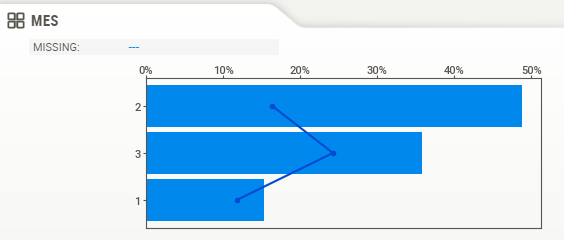


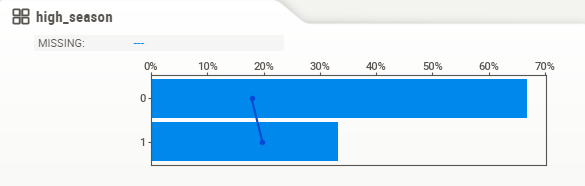

The day variable also has now a clear relation with the target variable 

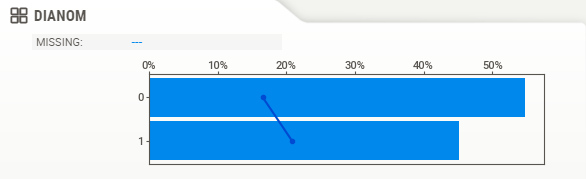

For the rest of the features is still required to apply a target encoding. 

Regarding the variables that may have the larget impact on the model: 

* Mes: I expect this variable to have a large impact on the model. 

* TIPOVUELO: I expect this variable to have a large impact on the model.

* OPERA (And similar): There is a large variance of the delay rate across the airlines, which is a good sign for the model. But they also have a large cardinality and are largely invalanced, so may need further work in order to encode the information propertly. 

* SIGLADES (And similar): Similarly to the opera variable there is a large variance of the delay rate and a high cardinality, with the advantage of been more balanced that 'OPERA'. The disadvantage is that a large proportion of its information may be already encoded in the variable 'TIPOVUELO'


In [97]:
df_train

,Des-I,Emp-I,Des-O,Emp-O,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,high_season,period_day,delay_15
0,SPJC,SKU,SPJC,SKU,3,1,1,Sky Airline,Lima,0,0,1
1,SCIE,LAW,SCIE,JMR,1,1,0,Latin American Wings,Concepcion,0,0,0
2,MPTO,CMP,MPTO,CMP,2,1,1,Copa Air,Ciudad de Panama,0,0,1
3,SCTE,LAN,SCTE,LXP,2,1,0,Grupo LATAM,Puerto Montt,0,0,1
4,SBGR,TAM,SBGR,TAM,2,1,1,Grupo LATAM,Sao Paulo,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54559,SAME,LAN,SAME,LAN,2,1,1,Grupo LATAM,Mendoza,1,0,0
54560,SBGL,TAM,SBGL,TAM,2,0,1,Grupo LATAM,Rio de Janeiro,0,1,1
54561,SCCF,SKU,SCCF,SKU,3,0,0,Sky Airline,Calama,0,0,0
54562,SCTE,LAN,SCTE,LAN,3,0,0,Grupo LATAM,Puerto Montt,0,1,0


# Question 4: 

 Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.
Feel free to generate additional variables and/or supplement with external variables.

The first step is is to encode the categorical features with high cardinality, for that I used two methods:  weight of evidence (WoE) and Cat encoder, and compare the results with a logistic regresion model

In [98]:
woee =  ce.woe.WOEEncoder()
cat_encoder = ce.cat_boost.CatBoostEncoder()

In [100]:
X = df_train.drop('delay_15', axis=1)
y = df_train['delay_15']
# drop the month column
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)


In [101]:
hcardinality = ['Des-I', 'Emp-I', 'Des-O', 'Emp-O','SIGLADES','OPERA']

woe_features_train  =  woee.fit_transform(X_train[hcardinality], y_train)
cat_encoder_features_train = cat_encoder.fit_transform(X_train[hcardinality], y_train)

In [102]:
# add _ woe to the columns names
woe_features_train.columns = [col + '_woe' for col in woe_features_train.columns]
# add _ cat to the columns names 
cat_encoder_features_train.columns = [col + '_cat' for col in cat_encoder_features_train.columns]

In [103]:
# create the woe and cat encoder for the validation set 
woe_features_val  =  woee.transform(X_val[hcardinality])
cat_encoder_features_val = cat_encoder.transform(X_val[hcardinality])

# add _ woe to the columns names
woe_features_val.columns = [col + '_woe' for col in woe_features_val.columns]
# add _ cat to the columns names
cat_encoder_features_val.columns = [col + '_cat' for col in cat_encoder_features_val.columns]


In [104]:
X_train = X_train.drop(hcardinality, axis=1) 
X_val   = X_val.drop(hcardinality, axis=1)
X_train = pd.concat([X_train, woe_features_train, cat_encoder_features_train], axis=1)
X_val   = pd.concat([X_val, woe_features_val, cat_encoder_features_val], axis=1)


First I trained a logistic regression model with the simplest features to have it as a baseline 

Train data report
              precision    recall  f1-score   support

           0       0.88      0.64      0.74     35578
           1       0.28      0.60      0.38      8073

    accuracy                           0.63     43651
   macro avg       0.58      0.62      0.56     43651
weighted avg       0.76      0.63      0.67     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      8895
           1       0.27      0.61      0.37      2018

    accuracy                           0.62     10913
   macro avg       0.57      0.62      0.55     10913
weighted avg       0.76      0.62      0.66     10913



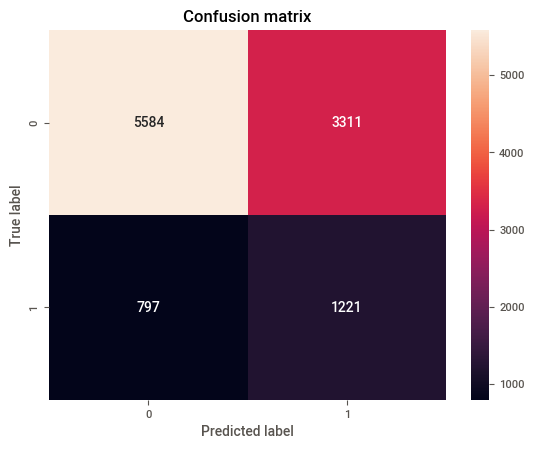

In [112]:
features = ['MES', 'DIANOM', 'TIPOVUELO', 'high_season', 'period_day', 
       'Des-I_cat', 'Emp-I_cat', 'SIGLADES_cat',    'OPERA_cat']

logreg = LogisticRegression(class_weight='balanced')
model = train_base_model(logreg, X_train, y_train, X_val, y_val, features)

Now that we have a frame of reference we can try adding the cat and woe encoded features: 

Train data report
              precision    recall  f1-score   support

           0       0.88      0.64      0.74     35578
           1       0.28      0.60      0.38      8073

    accuracy                           0.63     43651
   macro avg       0.58      0.62      0.56     43651
weighted avg       0.76      0.63      0.67     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      8895
           1       0.27      0.61      0.37      2018

    accuracy                           0.62     10913
   macro avg       0.57      0.62      0.55     10913
weighted avg       0.76      0.62      0.66     10913



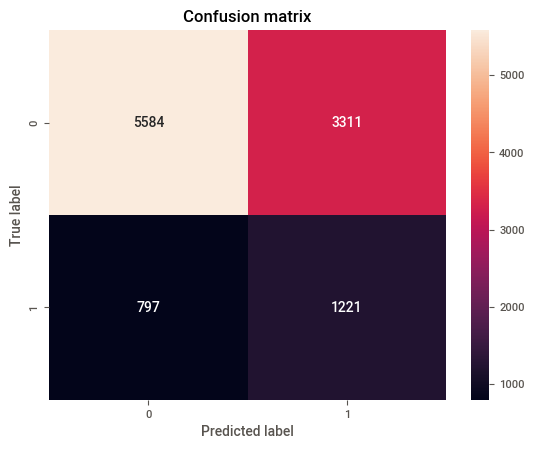

LogisticRegression(class_weight='balanced')

In [88]:
features = ['MES', 'DIANOM', 'TIPOVUELO', 'high_season', 'period_day', 
       'Des-I_cat', 'Emp-I_cat', 'SIGLADES_cat',    'OPERA_cat']

logreg = LogisticRegression(class_weight='balanced')

train_base_model(logreg,X_train, y_train, X_val, y_val,features)

Train data report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73     35578
           1       0.28      0.62      0.38      8073

    accuracy                           0.63     43651
   macro avg       0.58      0.63      0.56     43651
weighted avg       0.77      0.63      0.67     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      8895
           1       0.27      0.61      0.38      2018

    accuracy                           0.62     10913
   macro avg       0.57      0.62      0.55     10913
weighted avg       0.76      0.62      0.66     10913



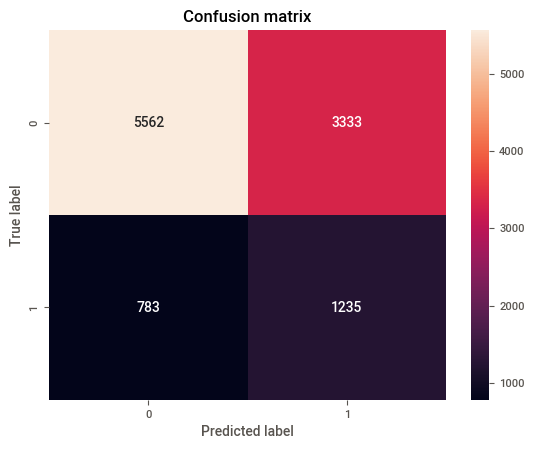

(LogisticRegression(class_weight='balanced'),
        MES  DIANOM  TIPOVUELO  high_season  period_day  Des-I_woe  Emp-I_woe  \
 45845    1       1          1            0           0   0.292000  -0.098925   
 30642    3       0          0            1           1  -0.269849  -0.098925   
 4011     2       1          0            1           0  -0.260363  -0.098925   
 46480    2       0          0            1           1  -0.106439  -0.098925   
 9279     3       0          0            0           0  -0.260363  -0.098925   
 ...    ...     ...        ...          ...         ...        ...        ...   
 6298     2       0          0            1           0  -0.523308  -0.098925   
 420      3       0          0            0           0  -0.140231  -0.098925   
 38183    3       1          1            0           0   0.333014  -0.113440   
 45600    3       0          0            1           0  -0.232587  -0.098925   
 53613    1       0          0            0           0  -0.140

In [97]:
features = ['MES', 'DIANOM', 'TIPOVUELO', 'high_season', 'period_day', 
       'Des-I_woe', 'Emp-I_woe', 'SIGLADES_woe',    'OPERA_woe']

logreg = LogisticRegression(class_weight='balanced')

train_base_model(logreg,X_train, y_train, X_val, y_val,features)
(logreg,X_train, y_train, X_val, y_val,features)

In [ ]:
# really no better 



In [89]:
# create a lgbm classifier with balanced class weights 
# create a lgbm classifier with balanced class weights
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)


Train data report
              precision    recall  f1-score   support

           0       0.90      0.64      0.75     35578
           1       0.30      0.68      0.41      8073

    accuracy                           0.65     43651
   macro avg       0.60      0.66      0.58     43651
weighted avg       0.79      0.65      0.68     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.63      0.73      8895
           1       0.28      0.64      0.39      2018

    accuracy                           0.63     10913
   macro avg       0.58      0.63      0.56     10913
weighted avg       0.77      0.63      0.67     10913



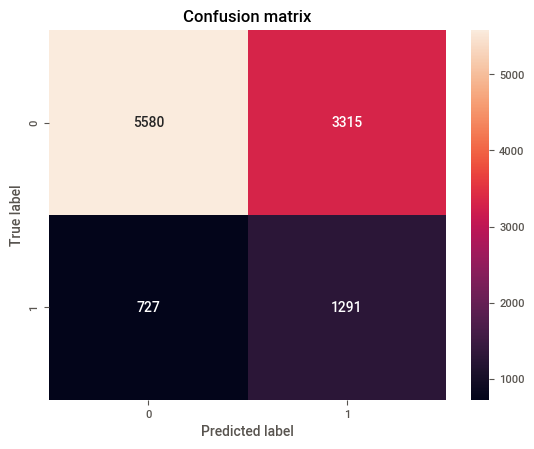

LGBMClassifier(class_weight='balanced', random_state=0)

In [98]:

train_base_model(lgbm,X_train, y_train, X_val, y_val,features)

In [ ]:

# slightly better 

In [91]:
# optimize the hyperparameters of the lgbm classifier 


# define the parameter space
param_space = { 'n_estimators': sp_randint(50, 200),
                'max_depth': sp_randint(3, 5), 
                'num_leaves': sp_randint(6, 20),
                'learning_rate': sp_uniform(loc=0.01, scale=0.2),
                'subsample': sp_uniform(loc=0.2, scale=0.8),
                'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                'min_child_samples': sp_randint(10, 50)
                }

# create the classifier

lgbm = LGBMClassifier(class_weight='balanced', random_state=0)

# create the random search
random_search = RandomizedSearchCV(lgbm, param_distributions=param_space, n_iter=50,
                                      scoring='f1', n_jobs=-1, cv=3, random_state=0)    

# run the random search
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9d01eaa0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9d01d6f0>,
                                        'max_depth': <scipy.stats._d...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3f9d01cc70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3f9cfa7eb0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3f9cfc1de0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9d01d780>},
                   random_state=0, scoring='f1')

In [101]:
# show the metric of the best model
print('Best F1 score: ', random_search.best_score_)
print('Best parameters: ', random_search.best_params_)
# Best F1 score:  0.9999999999999999


# assign the best model to the variable model 
model = random_search.best_estimator_


Best F1 score:  0.38737311577983763
Best parameters:  {'colsample_bytree': 0.6937293621346563, 'learning_rate': 0.07779702335595565, 'max_depth': 4, 'min_child_samples': 46, 'n_estimators': 50, 'num_leaves': 17, 'subsample': 0.5707607819075864}


Train data report
              precision    recall  f1-score   support

           0       0.89      0.61      0.72     35578
           1       0.28      0.67      0.39      8073

    accuracy                           0.62     43651
   macro avg       0.58      0.64      0.56     43651
weighted avg       0.78      0.62      0.66     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      8895
           1       0.27      0.65      0.38      2018

    accuracy                           0.61     10913
   macro avg       0.58      0.63      0.55     10913
weighted avg       0.77      0.61      0.65     10913



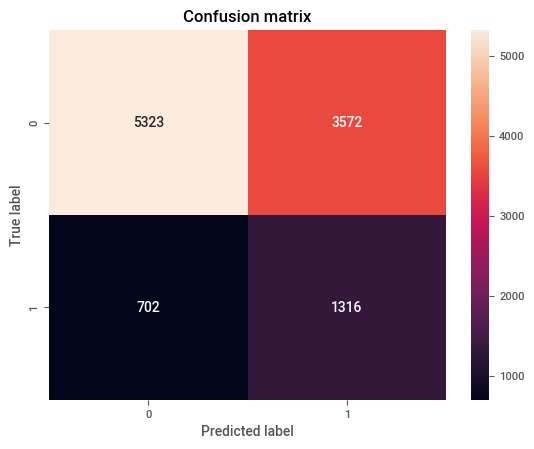

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6937293621346563,
               learning_rate=0.07779702335595565, max_depth=4,
               min_child_samples=46, n_estimators=50, num_leaves=17,
               random_state=0, subsample=0.5707607819075864)

In [102]:
train_base_model(model,X_train, y_train, X_val, y_val,features)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

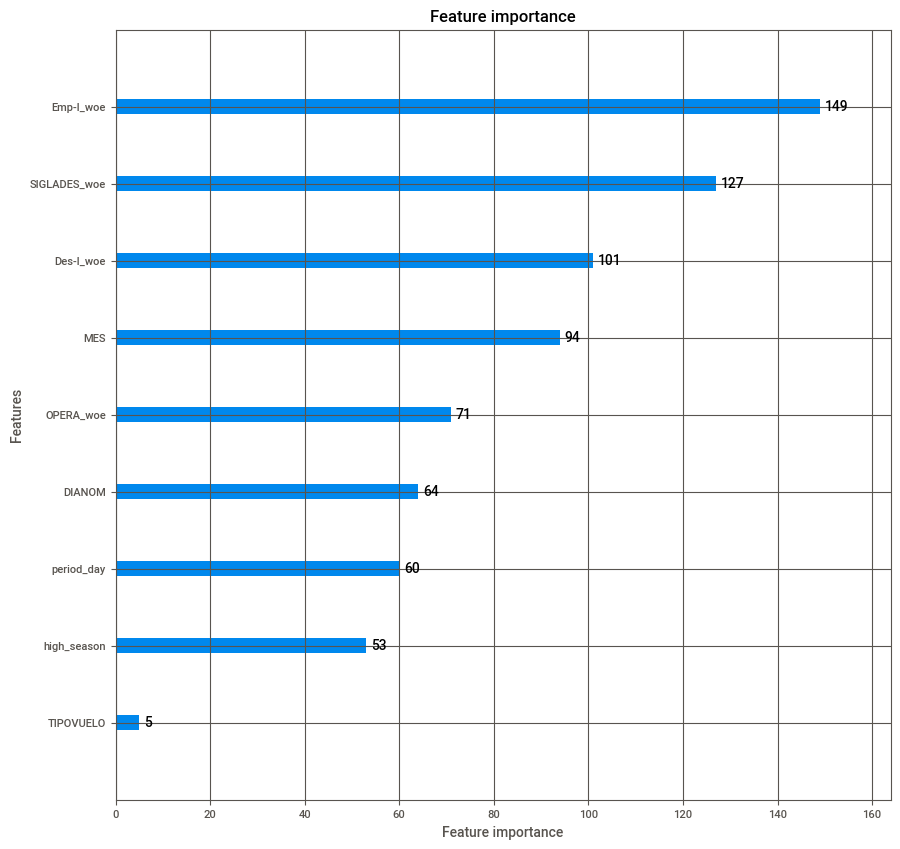

In [105]:
import lightgbm 
lightgbm.plot_importance(model, max_num_features=10, figsize=(10, 10))


# not much better the problem is in the encoding of the features 

In [ ]:
# lets look into it 

In [125]:

airlines = {"Copa Air": 1,
            "American Airlines": 1,
            "Iberia": 1,
            "Delta Air": 1,
            "Aeromexico": 1,
            "United Airlines": 1,
            "Alitalia": 1,
            "Latin American Wings": 3,
            "Gol Trans": 3}

# Create the default dictionary with the default value of 2
airlines_dict = defaultdict(lambda: 2)

for k,v in airlines.items():
    airlines_dict[k] = v
    


airlines_dict['Copa Air']

1

In [126]:
dest = {"Ciudad de Panama":1,
"Calama":2,
"Antofagasta":3,
"Concepcion":3,
"Iquique":3,
"Temuco":3,
"Arica":3,
"La Serena":3,
"Copiapo":3,
"Buenos Aires":5,
"Lima":5,
"Sao Paulo":5,
"Bogota":5,
"Rio de Janeiro":5,
"Mendoza":5,
}

dest_dict = defaultdict(lambda: 4)

for k,v in dest.items():
    dest_dict[k] = v
    



In [128]:
df_train_copy = df_train.copy() 
df_train_copy

,Des-I,Emp-I,Des-O,Emp-O,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,month,high_season,period_day,delay_15
0,SPJC,SKU,SPJC,SKU,3,1,1,Sky Airline,Lima,11,0,0,1
1,SCIE,LAW,SCIE,JMR,1,1,0,Latin American Wings,Concepcion,4,0,0,0
2,MPTO,CMP,MPTO,CMP,2,1,1,Copa Air,Ciudad de Panama,6,0,0,1
3,SCTE,LAN,SCTE,LXP,2,1,0,Grupo LATAM,Puerto Montt,6,0,0,1
4,SBGR,TAM,SBGR,TAM,2,1,1,Grupo LATAM,Sao Paulo,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54559,SAME,LAN,SAME,LAN,2,1,1,Grupo LATAM,Mendoza,9,1,0,0
54560,SBGL,TAM,SBGL,TAM,2,0,1,Grupo LATAM,Rio de Janeiro,6,0,1,1
54561,SCCF,SKU,SCCF,SKU,3,0,0,Sky Airline,Calama,11,0,0,0
54562,SCTE,LAN,SCTE,LAN,3,0,0,Grupo LATAM,Puerto Montt,10,0,1,0


In [129]:
# map the columns to the dictionaries 
df_train_copy['OPERA'] = df_train_copy['OPERA'].map(airlines_dict)
df_train_copy['SIGLADES'] = df_train_copy['SIGLADES'].map(dest_dict)


In [130]:
cols = ['MES', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLADES', 'month', 'high_season', 'period_day', 'delay_15']

df_train_copy  = df_train_copy[cols] 

In [131]:
df_train_copy

# make as switviz report
my_report = sv.analyze(df_train_copy,target_feat='delay_15')
my_report.show_html(filepath='./reports/EDA_manual_report.html') 

/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: delay_15 (TARGET)                   |█         | [ 10%]   00:00 -> (00:00 left)/home/codespace/.python/current/lib/python3.10/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: MES                                 |██        | [ 20%]   00:00 -> (00:00 left)/home/codespace/.

Report ./reports/EDA_manual_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [132]:
X = df_train_copy.drop('delay_15', axis=1)
y = df_train_copy['delay_15']
# drop the month column
X = X.drop('month', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

In [133]:
X_train.columns

Index(['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'high_season',
       'period_day'],
      dtype='object')

In [135]:
# define the parameter space
param_space = { 'n_estimators': sp_randint(50, 200),
                'max_depth': sp_randint(3, 5), 
                'num_leaves': sp_randint(6, 20),
                'learning_rate': sp_uniform(loc=0.01, scale=0.2),
                'subsample': sp_uniform(loc=0.2, scale=0.8),
                'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                'min_child_samples': sp_randint(10, 50)
                }

# create the classifier

lgbm = LGBMClassifier(class_weight='balanced', random_state=0)

# create the random search
random_search = RandomizedSearchCV(lgbm, param_distributions=param_space, n_iter=50,
                                      scoring='f1', n_jobs=-1, cv=3, random_state=0)    

# run the random search
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9c181ae0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9e5d2740>,
                                        'max_depth': <scipy.stats._d...
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3f9e334040>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3f9c83b8b0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3fa1c96ec0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3f9c181a20>},
                   random_state=0, scoring='f1')

Best F1 score:  0.37877894276163654
Best parameters:  {'colsample_bytree': 0.6768876173517591, 'learning_rate': 0.1661058352572911, 'max_depth': 3, 'min_child_samples': 49, 'n_estimators': 82, 'num_leaves': 7, 'subsample': 0.31468262992723717}
Train data report
              precision    recall  f1-score   support

           0       0.89      0.55      0.68     35578
           1       0.26      0.69      0.38      8073

    accuracy                           0.58     43651
   macro avg       0.57      0.62      0.53     43651
weighted avg       0.77      0.58      0.63     43651

Test data report
              precision    recall  f1-score   support

           0       0.88      0.55      0.68      8895
           1       0.26      0.68      0.37      2018

    accuracy                           0.57     10913
   macro avg       0.57      0.62      0.52     10913
weighted avg       0.77      0.57      0.62     10913



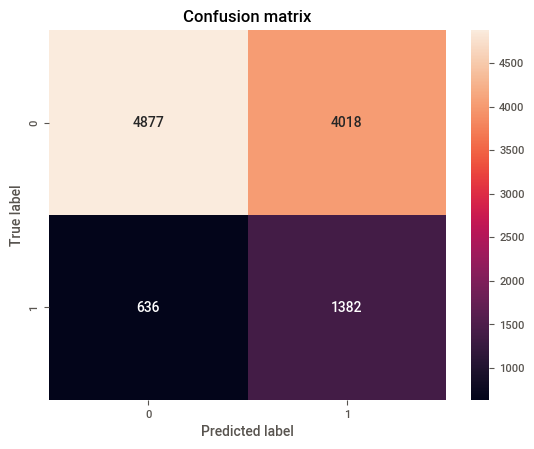

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6768876173517591,
               learning_rate=0.1661058352572911, max_depth=3,
               min_child_samples=49, n_estimators=82, num_leaves=7,
               random_state=0, subsample=0.31468262992723717)

In [136]:
# show the metric of the best model
print('Best F1 score: ', random_search.best_score_)
print('Best parameters: ', random_search.best_params_)
# Best F1 score:  0.9999999999999999


# assign the best model to the variable model 
model = random_search.best_estimator_
train_base_model(model,X_train, y_train, X_val, y_val,features)


In [140]:
# make a prediction on the train set  return the label and the score 
y_pred_train = model.predict(X_train)
y_pred_train_proba = model.predict_proba(X_train)[:,1]


In [159]:
# create a dataframe with y_pred_train and y_pred_train_proba
df_train_pred22 = pd.DataFrame({'y_pred_train': y_pred_train, 'y_pred_train_proba': y_pred_train_proba,'y_train': y_train})
df_train_pred22

# only kept the prediction were the model has over 70% of confidence or below 30% of confidence 
df_train_pred22 = df_train_pred22[(df_train_pred22['y_pred_train_proba'] > 0.6) | (df_train_pred22['y_pred_train_proba'] < 0.4)]
df_train_pred22

,y_pred_train,y_pred_train_proba,y_train
46480,0,0.306895,0
11894,0,0.356832,0
20983,1,0.667040,1
27663,0,0.263523,0
46443,0,0.336809,0
...,...,...,...
22064,0,0.278581,0
6298,0,0.278581,0
38183,1,0.671944,0
45600,1,0.636680,0
